In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm


def scaled_sigmoid(x: float, start: float, end: float) -> float:
    """当`x`落在`[start,end]`区间时，函数值为[0,1]且在该区间有较好的响应灵敏度"""
    n = np.abs(start - end)
    score = 2 / (1 + np.exp(-np.log(40_000) * (x - start - n) / n + np.log(5e-3)))
    return score / 2


def generate_px_pct_bar(
        df: pd.DataFrame,
        threshold: float,
        window: int,
) -> pd.DataFrame:
    last_px = df.iloc[0]["price"]
    last_ts = df.iloc[0]["transact_time"]

    bars = []
    sum_buy_size = 0
    sum_sell_size = 0

    print(last_px)
    for i, row in tqdm(df.iterrows(), desc='Processing bars', total=len(df)):
        px = row["price"]
        sz = row["quantity"]
        ts = row["transact_time"]
        side = -1 if row["is_buyer_maker"] else 1  # 卖方主导为 -1，买方主导为 1

        px_pct = (px - last_px) / last_px

        if side == 1:
            sum_buy_size += sz

        else:
            sum_sell_size += sz

        if abs(px_pct) > threshold:
            ts_duration = ts - last_ts

            bar = {
                "price": px,
                "sum_buy_size": sum_buy_size,
                "sum_sell_size": sum_sell_size,
                "timestamp_duration": ts_duration,
                "price_pct_change": px_pct,
                'buy_sell_imbalance': sum_buy_size - sum_sell_size,
                "change_side": 1 if px_pct > 0 else 0,
            }
            bars.append(bar)

            last_px = px
            last_ts = ts
            sum_buy_size = 0
            sum_sell_size = 0

    bars_df = pd.DataFrame(bars)
    bars_df['future_price_pct_change'] = bars_df['price'].shift(-window) / bars_df['price'] - 1
    bars_df = bars_df.dropna()
    bars_df['scaled_sigmoid_future_price_pct_change'] = bars_df['future_price_pct_change'].apply(
        lambda x: scaled_sigmoid(x, -threshold * float(window), threshold * float(window))
    )
    return bars_df


def normalize_data(df: pd.DataFrame) -> pd.DataFrame:
    df_normalized = df.copy()

    df_normalized['scaled_sigmoid_price'] = df_normalized['price'].apply(
        lambda x: scaled_sigmoid(x, 0, 10)
    )
    df_normalized['scaled_sigmoid_sum_buy_size'] = df_normalized['sum_buy_size'].apply(
        lambda x: scaled_sigmoid(x, 0, 100_000)
    )
    df_normalized['scaled_sigmoid_sum_sell_size'] = df_normalized['sum_sell_size'].apply(
        lambda x: scaled_sigmoid(x, 0, 100_000)
    )
    df_normalized['scaled_sigmoid_timestamp_duration'] = df_normalized['timestamp_duration'].apply(
        lambda x: scaled_sigmoid(x, 0, 60_000)
    )
    df_normalized['scaled_sigmoid_price_pct_change'] = df_normalized['price_pct_change'].apply(
        lambda x: scaled_sigmoid(x, -1., 1.)
    )
    df_normalized['scaled_sigmoid_buy_sell_imbalance'] = df_normalized['buy_sell_imbalance'].apply(
        lambda x: scaled_sigmoid(x, -100_000, 100_000)
    )
    return df_normalized


if __name__ == "__main__":
    pd.set_option("display.max_rows", 5000)
    pd.set_option("expand_frame_repr", False)

    agg_trade_data = pd.read_csv("C:/Work Files/data/backtest/aggtrade/FILUSDT/FILUSDT-aggTrades-2024-04.csv")
    print(agg_trade_data)

    px_pct_bar = generate_px_pct_bar(
        df=agg_trade_data,
        threshold=0.01,
        window=3,
    )

    print(px_pct_bar)

    from sklearn.linear_model import Lasso
    from sklearn.model_selection import train_test_split

    X = px_pct_bar[[
        'price',
        'sum_buy_size',
        'sum_sell_size',
        'timestamp_duration',
        'timestamp_duration',
        'price_pct_change',
        'buy_sell_imbalance',
        'change_side'
    ]]

    y = px_pct_bar['future_price_pct_change']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train, y_train)

    print("Lasso Coefficients:", lasso.coef_)
    print("Intercept:", lasso.intercept_)

    # 测试集上进行预测
    y_pred = lasso.predict(X_test)



In [2]:
import pandas as pd 
pd.set_option("display.max_rows", 5000)
pd.set_option("expand_frame_repr", False)

agg_trade_data = pd.read_csv("C:/Work Files/data/backtest/aggtrade/FILUSDT/FILUSDT-aggTrades-2024-04.csv")
print(agg_trade_data)

         agg_trade_id  price  quantity  first_trade_id  last_trade_id  transact_time  is_buyer_maker
0           272637339  9.972     115.9       632223322      632223326  1711929600021           False
1           272637340  9.973      11.0       632223327      632223328  1711929600027           False
2           272637341  9.973      24.8       632223329      632223333  1711929600232           False
3           272637342  9.973      74.5       632223334      632223335  1711929604764            True
4           272637343  9.974      44.6       632223336      632223340  1711929605043           False
...               ...    ...       ...             ...            ...            ...             ...
5790731     278428070  5.623     142.1       656988318      656988324  1714521596497            True
5790732     278428071  5.622      17.7       656988325      656988325  1714521597538            True
5790733     278428072  5.622       1.8       656988326      656988326  1714521597733       

In [3]:
px_pct_bar = generate_px_pct_bar(
    df=agg_trade_data,
    threshold=0.01,
    window=3,
)

print(px_pct_bar)

9.972


Processing bars: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5790736/5790736 [07:42<00:00, 12517.99it/s]


       price  sum_buy_size  sum_sell_size  timestamp_duration  price_pct_change  buy_sell_imbalance  change_side  future_price_pct_change
0     10.072  4.082017e+05       329341.3              721149          0.010028        78860.400000            1                 0.009929
1     10.173  5.405429e+05       575046.9             1172880          0.010028       -34504.000000            1                 0.009928
2     10.275  1.185006e+06      1262539.7             1979976          0.010027       -77534.000000            1                 0.009927
3     10.172  1.817146e+05       241666.8              176538         -0.010024       -59952.200000           -1                 0.009929
4     10.274  3.005935e+05       283026.1              528463          0.010028        17567.400000            1                -0.010123
5     10.377  3.290137e+05       215637.6              112929          0.010025       113376.100000            1                -0.029777
6     10.273  7.224115e+05       9

In [ ]:
normalized_bar = normalize_data(px_pct_bar)
print(normalized_bar)

In [9]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X = normalized_bar[[
    'scaled_sigmoid_price',
    'scaled_sigmoid_sum_buy_size',
    'scaled_sigmoid_sum_sell_size',
    'scaled_sigmoid_timestamp_duration',
    'scaled_sigmoid_price_pct_change',
    'scaled_sigmoid_buy_sell_imbalance',
    'change_side',
]]

y = px_pct_bar['scaled_sigmoid_future_price_pct_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

print("Lasso Coefficients:", lasso.coef_)
print("Intercept:", lasso.intercept_)

# 测试集上进行预测
y_predict = lasso.predict(X_test)

Lasso Coefficients: [-0.00000000e+00  2.63946056e-09 -3.41525855e-10 -4.93657985e-10
 -0.00000000e+00 -0.00000000e+00  1.23866198e-08 -0.00000000e+00]
Intercept: -0.0011257331764696935


In [10]:
from sklearn.metrics import mean_squared_error, r2_score

# 计算均方误差 (MSE)
mse = mean_squared_error(y_test, y_predict)
print(f"Mean Squared Error: {mse}")

# 计算 R²（决定系数）
r2 = r2_score(y_test, y_predict)
print(f"R²: {r2}")


Mean Squared Error: 0.0003045222826931809
R²: 0.012944635695792073


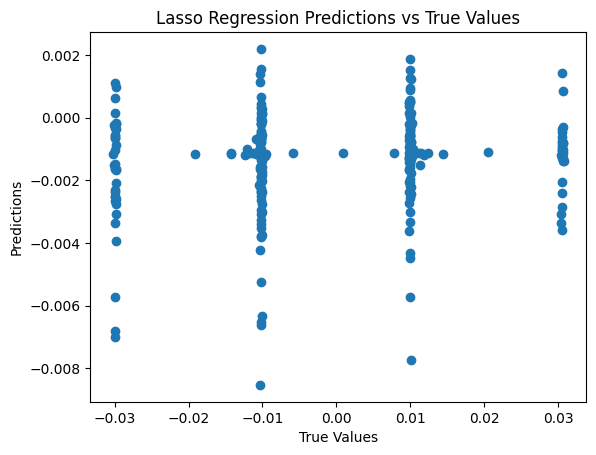

In [12]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_predict)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Lasso Regression Predictions vs True Values")
plt.show()
